# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [3]:
from python_environment_check import check_packages


d = {
    'torch': '1.8.0',
    'torchvision': '0.9.0',
    'numpy': '1.21.2',
    'matplotlib': '3.4.3',
}

check_packages(d)

[OK] torch 1.10.1
[OK] torchvision 0.11.2
[OK] numpy 1.21.5
[OK] matplotlib 3.5.1


# Chapter 17 - Generative Adversarial Networks for Synthesizing New Data (Part 2/2)

**Contents**

- [Improving the quality of synthesized images using a convolutional and Wasserstein GAN](#Improving-the-quality-of-synthesized-images-using-a-convolutional-and-Wasserstein-GAN)
  - [Transposed convolution](#Transposed-convolution)
  - [Batch normalization](#Batch-normalization)
  - [Implementing the generator and discriminator](#Implementing-the-generator-and-discriminator)
  - [Dissimilarity measures between two distributions](#Dissimilarity-measures-between-two-distributions)
  - [Using EM distance in practice for GANs](#Using-EM-distance-in-practice-for-GANs)
  - [Gradient penalty](#Gradient-penalty)
  - [Implementing WGAN-GP to train the DCGAN model](#Implementing-WGAN-GP-to-train-the-DCGAN-model)
  - [Mode collapse](#Mode-collapse)
  - [Other GAN applications](#Other-GAN-applications)
- [Summary](#Summary)

Note that the optional watermark extension is a small IPython notebook plugin that I developed to make the code reproducible. You can just skip the following line(s).

In [2]:
%load_ext watermark
%watermark -a "Sebastian Raschka, Yuxi (Hayden) Liu & Vahid Mirjalili" -u -d -p numpy,scipy,matplotlib,torch

Author: Sebastian Raschka, Yuxi (Hayden) Liu & Vahid Mirjalili

Last updated: 2021-12-27

numpy     : 1.21.5
scipy     : 1.7.3
matplotlib: 3.5.1
torch     : 1.10.1



In [2]:
from IPython.display import Image
%matplotlib inline

# Improving the quality of synthesized images using a convolutional and Wasserstein GAN

## Transposed convolution

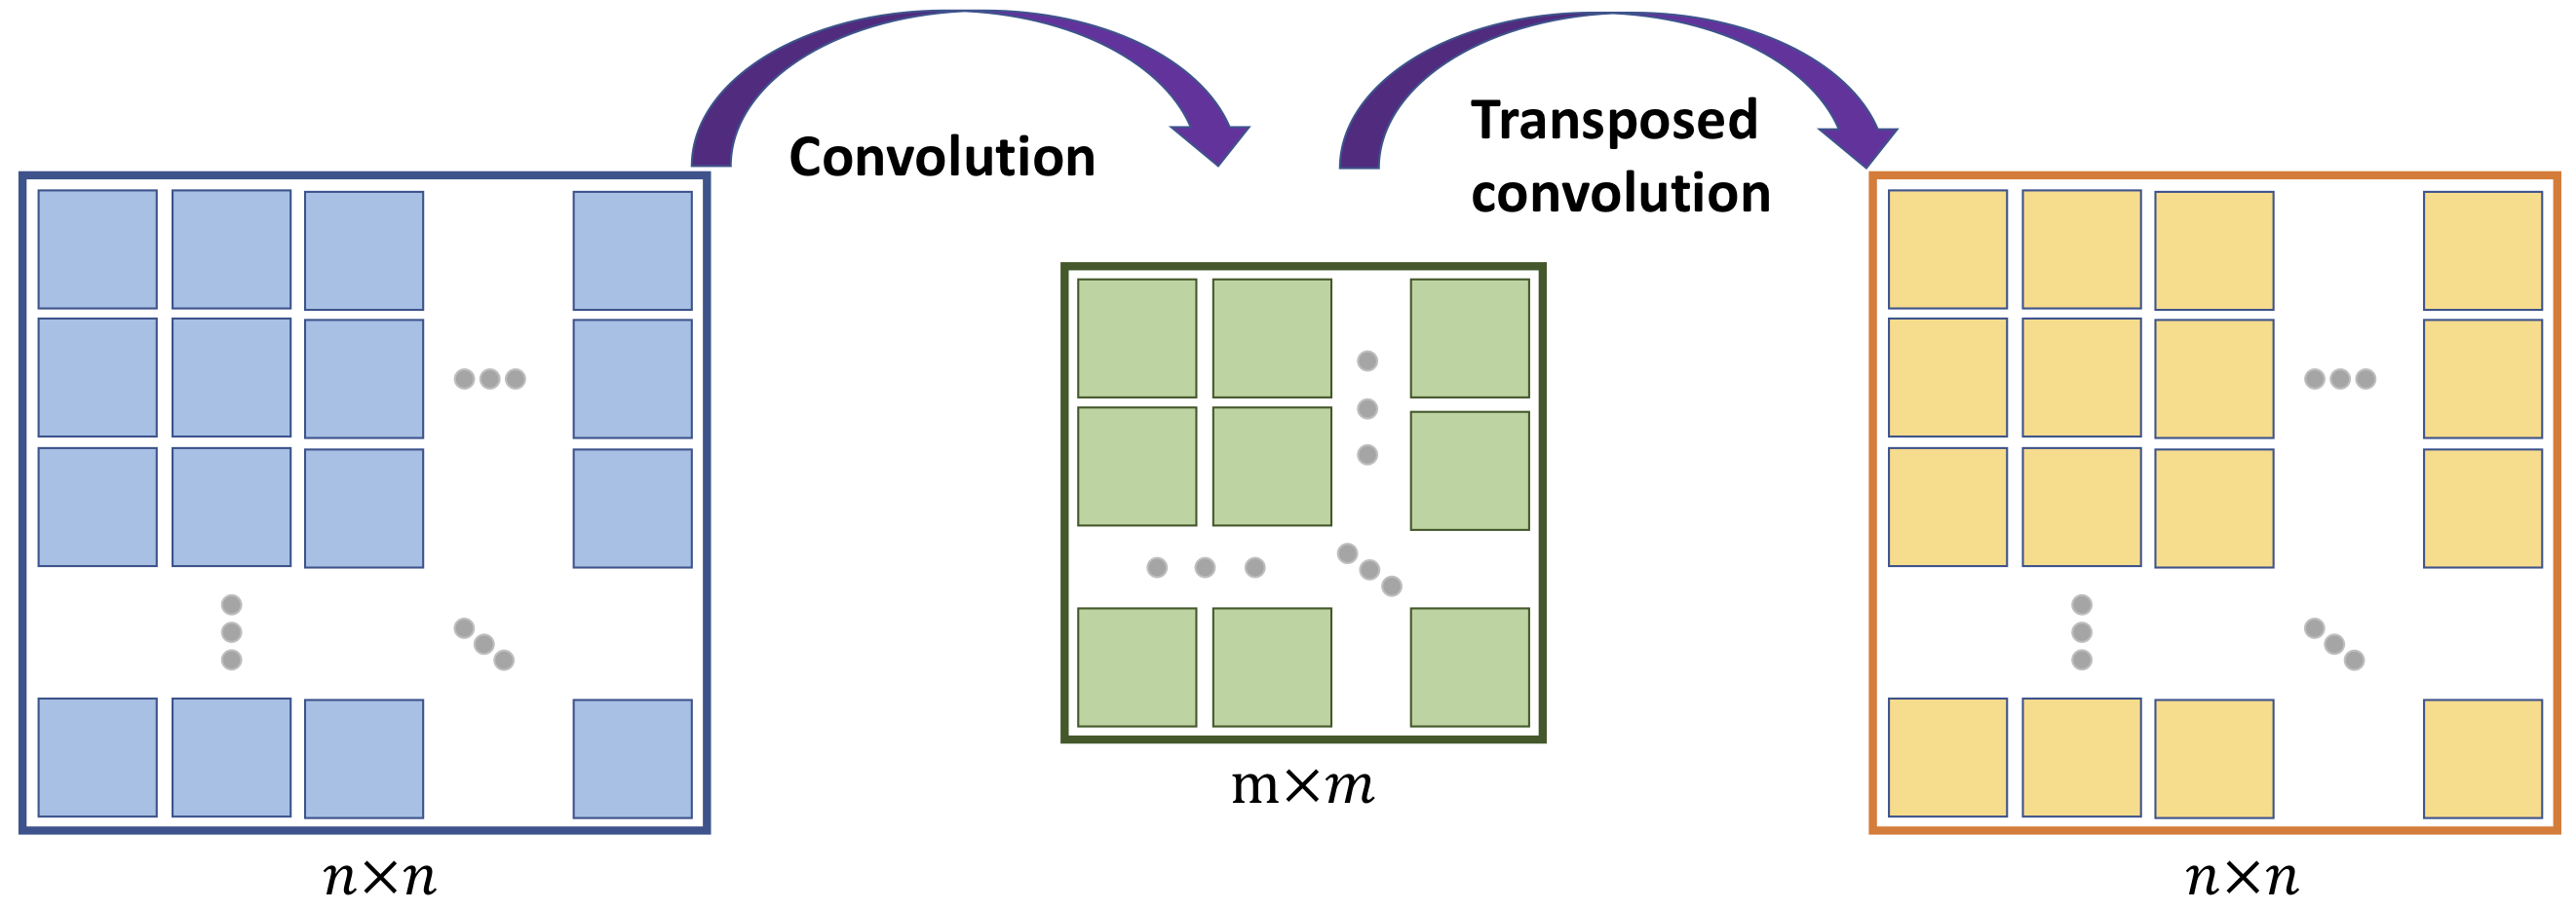

In [3]:
Image(filename='figures/17_09.png', width=700)

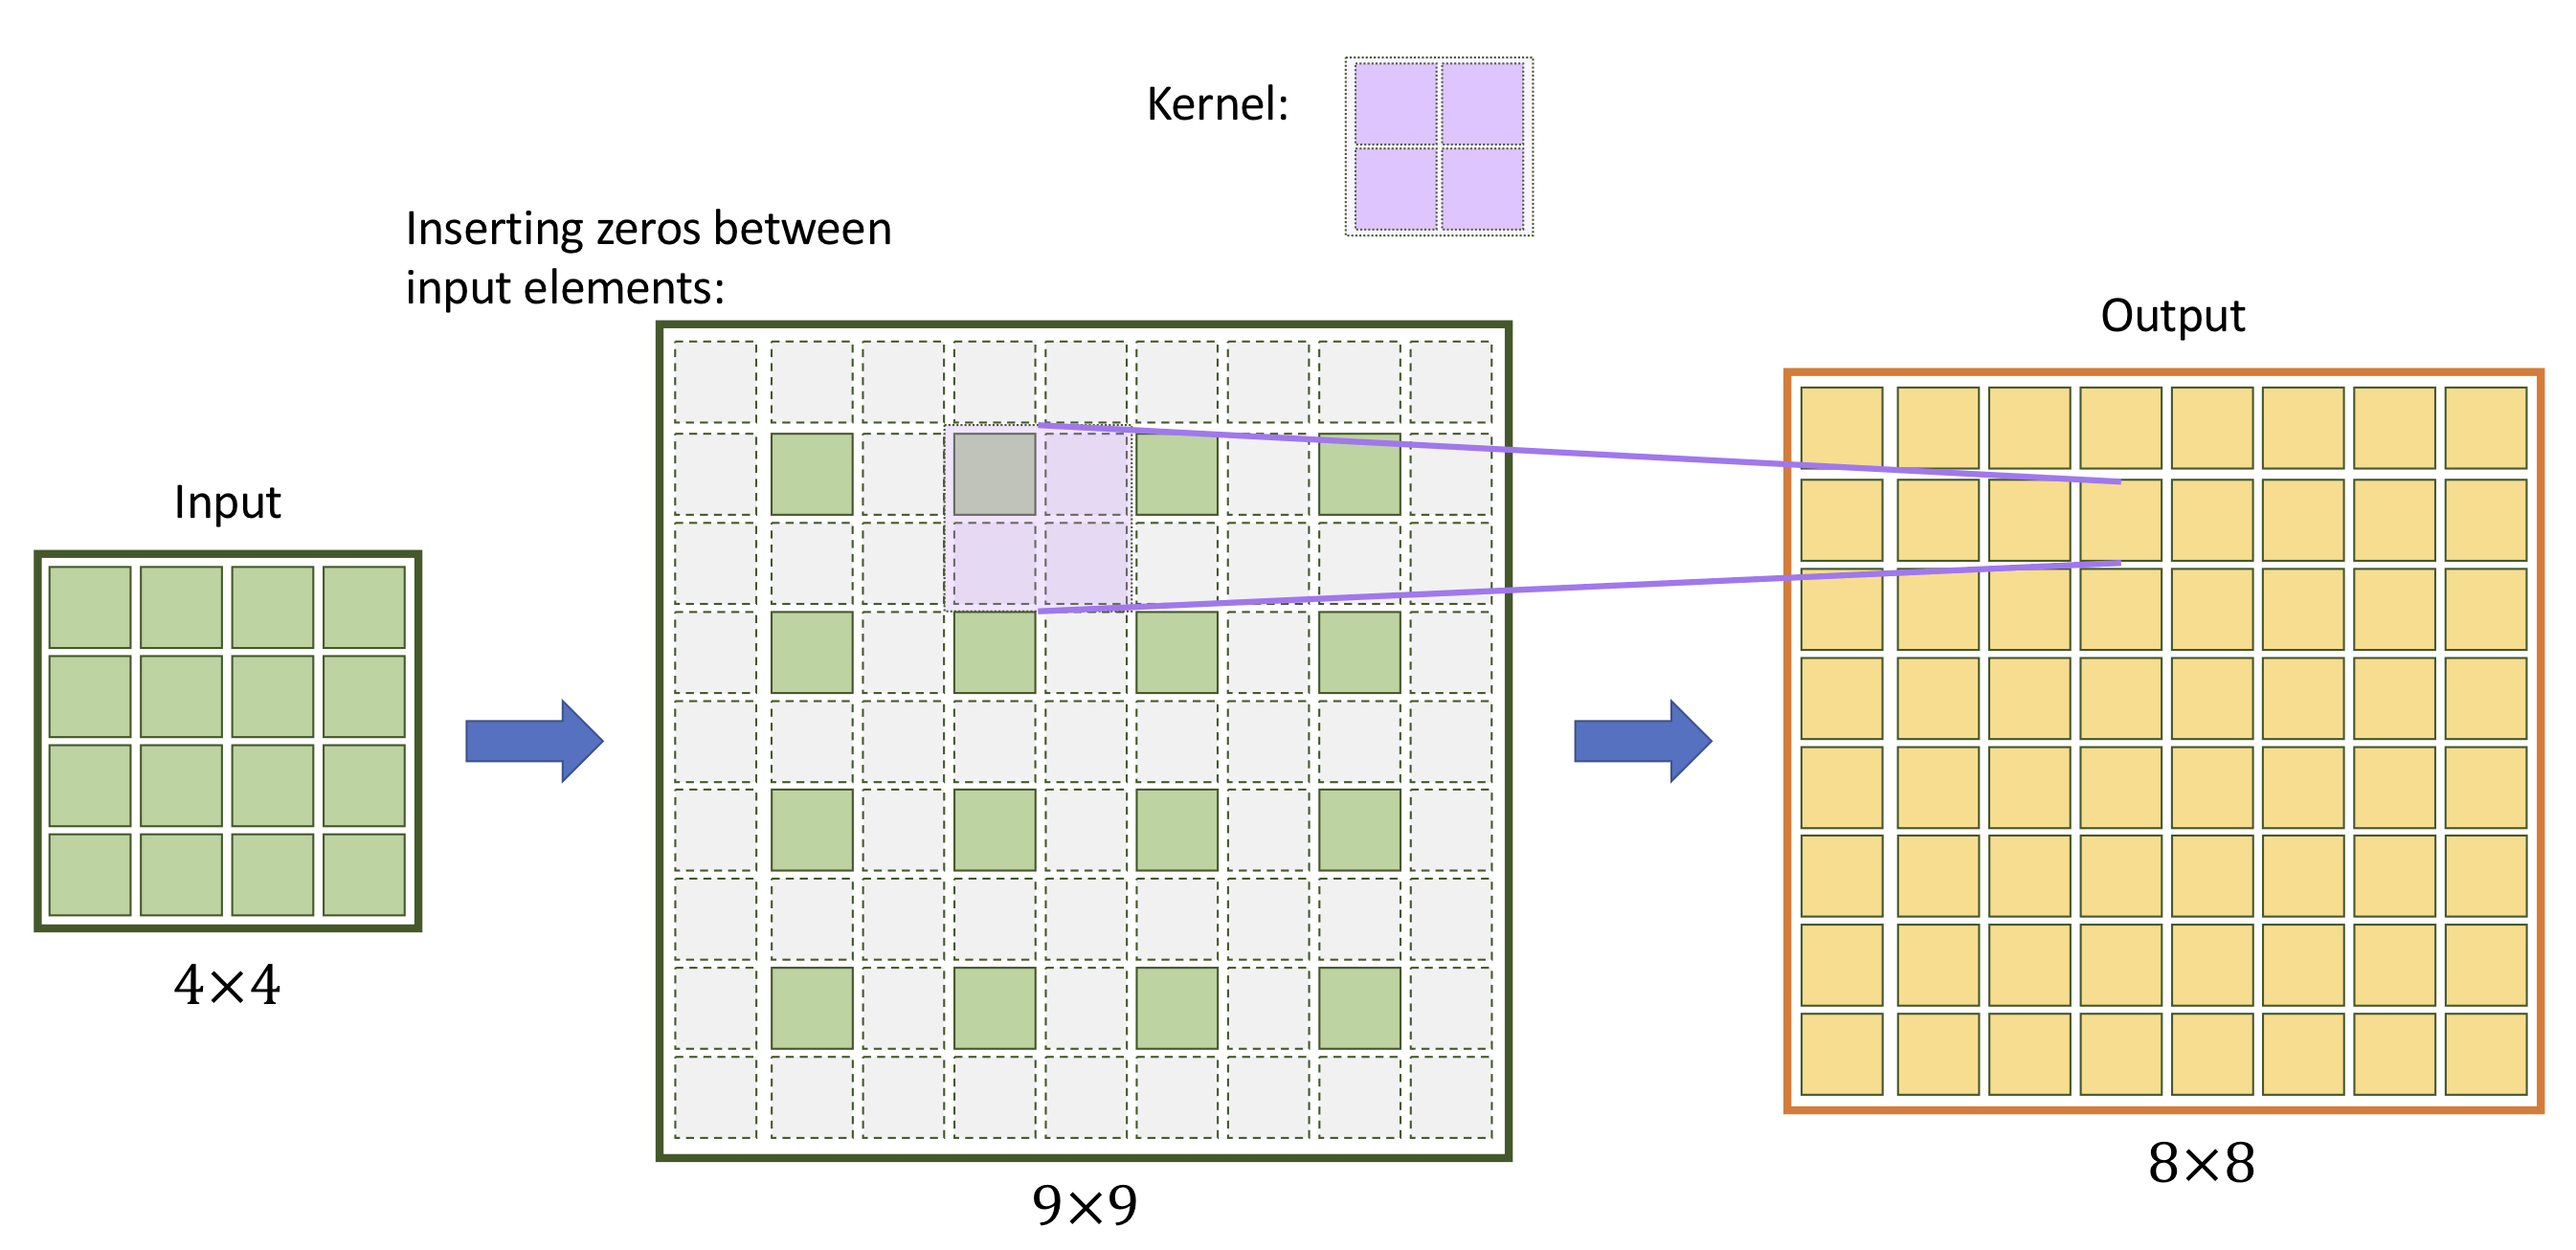

In [4]:
Image(filename='figures/17_10.png', width=700)

## Batch normalization

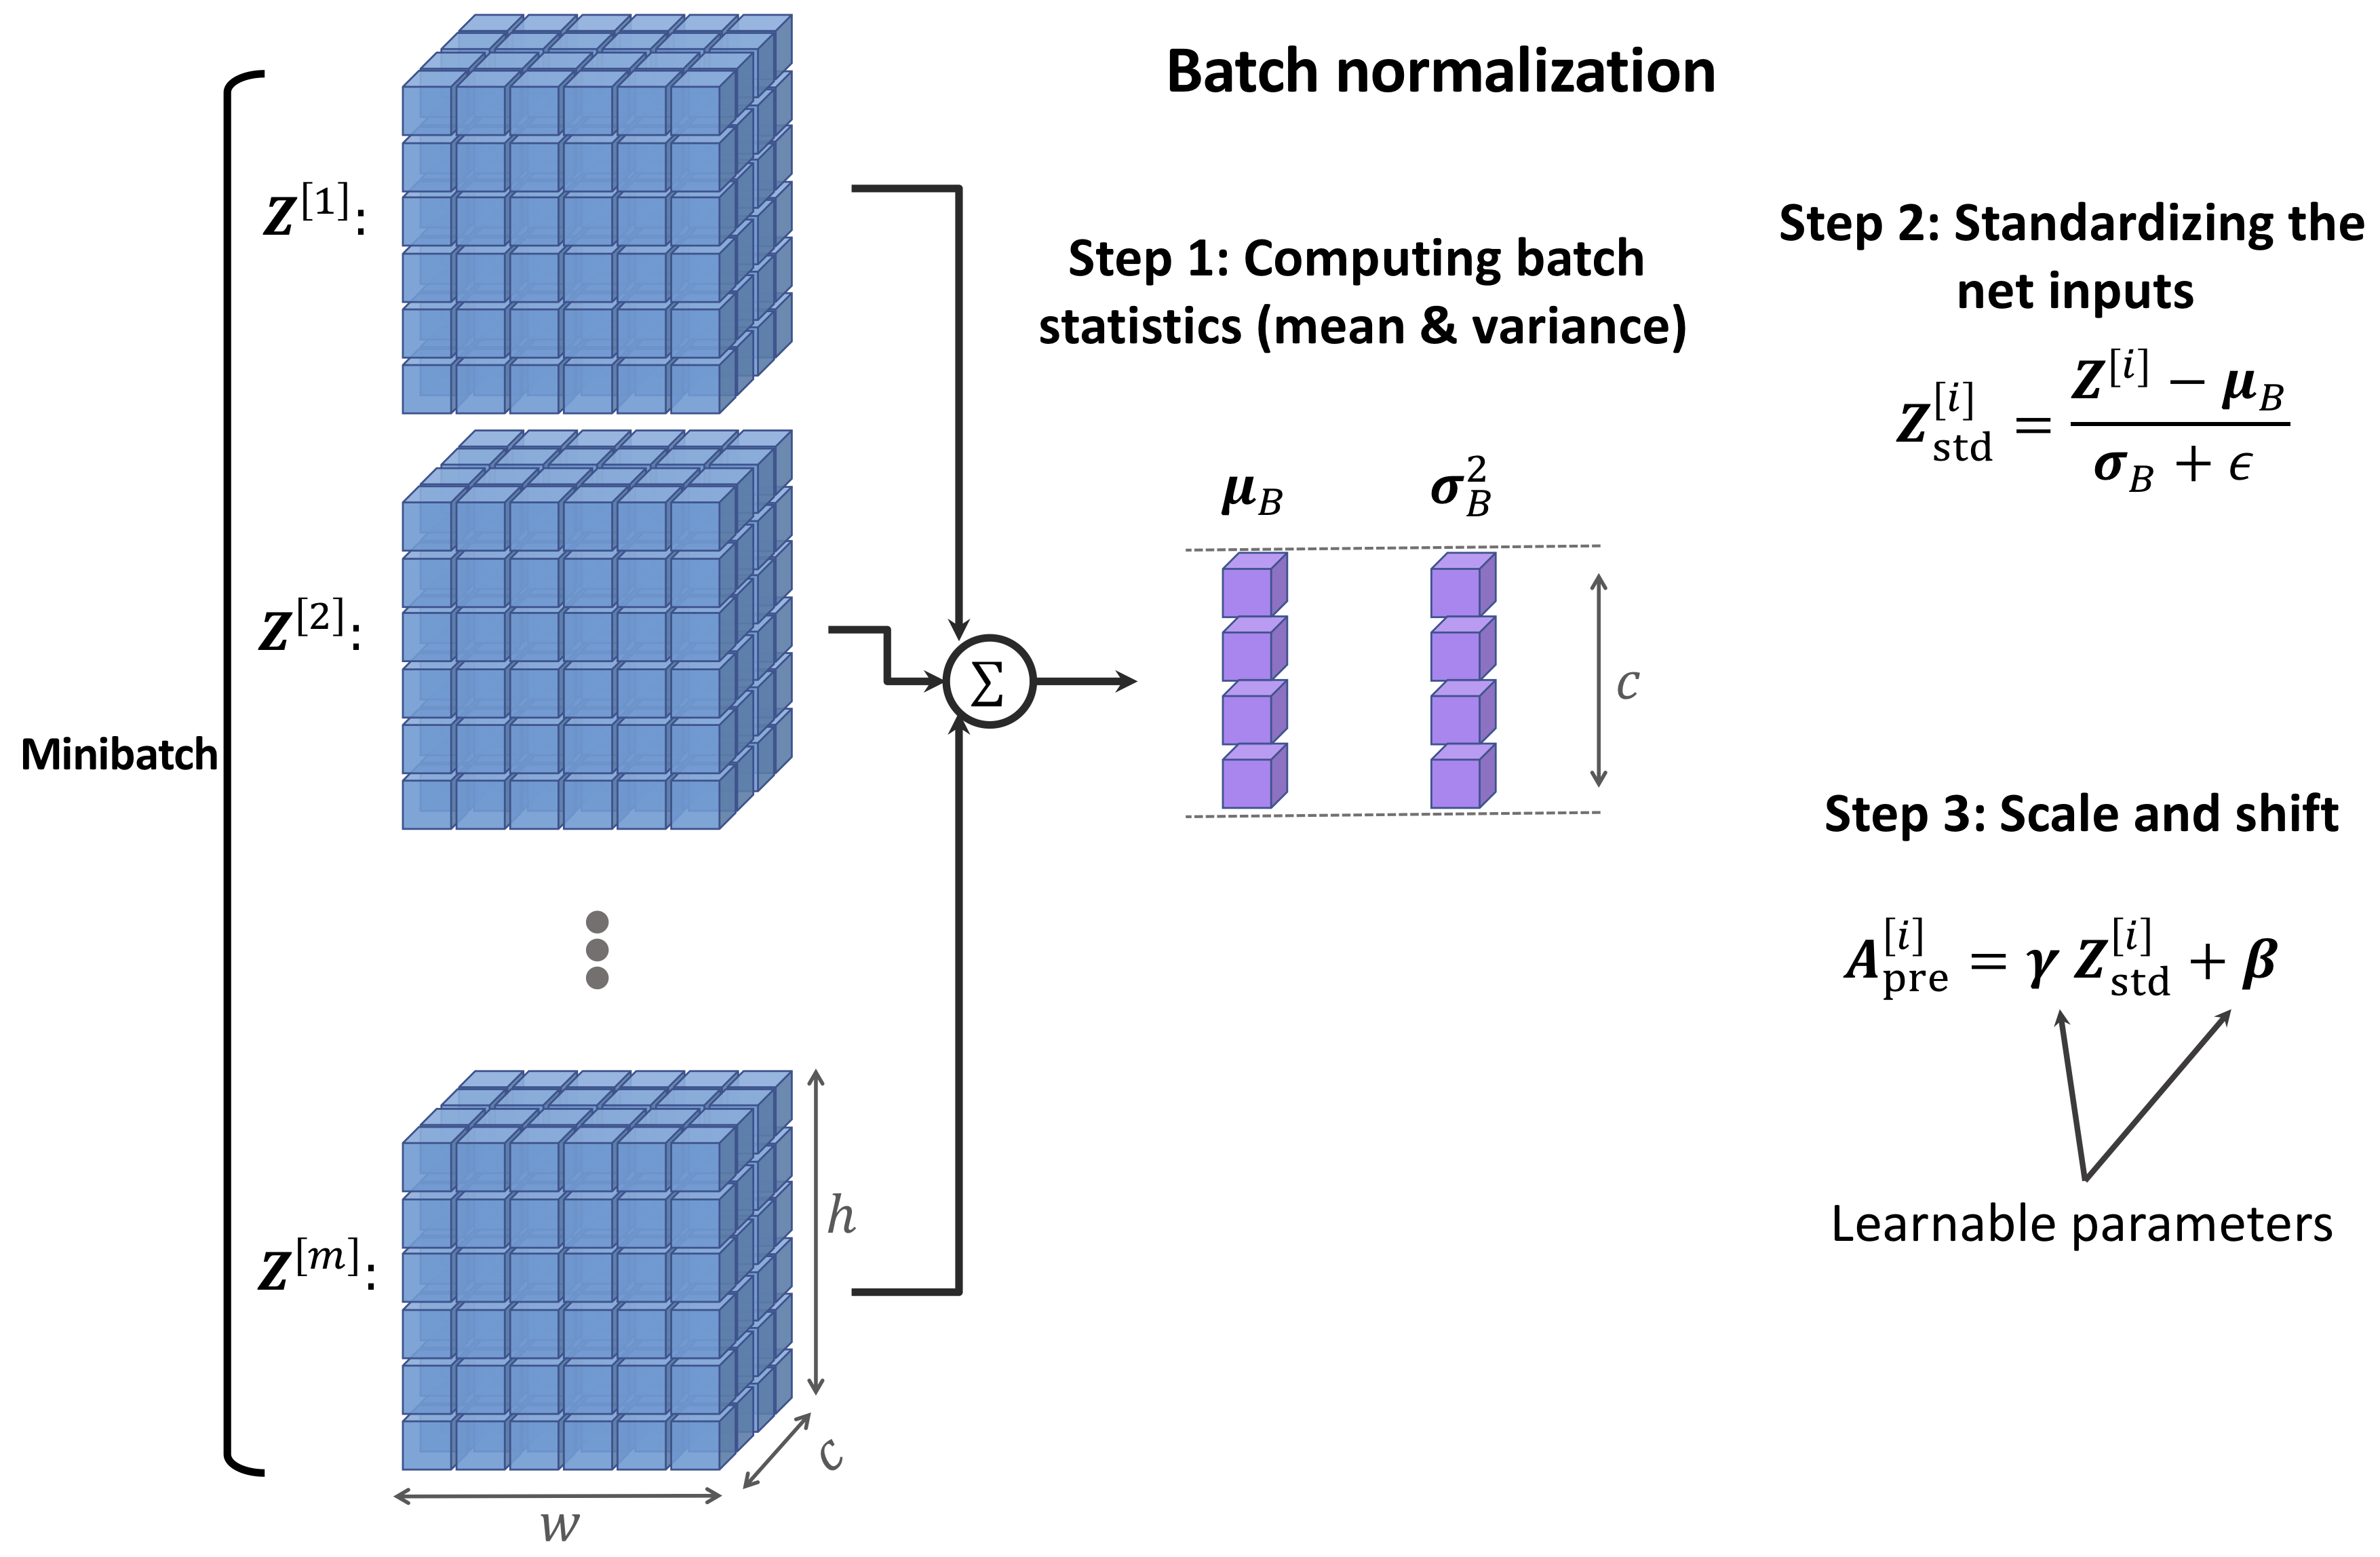

In [5]:
Image(filename='figures/17_11.png', width=700)

## Implementing the generator and discriminator

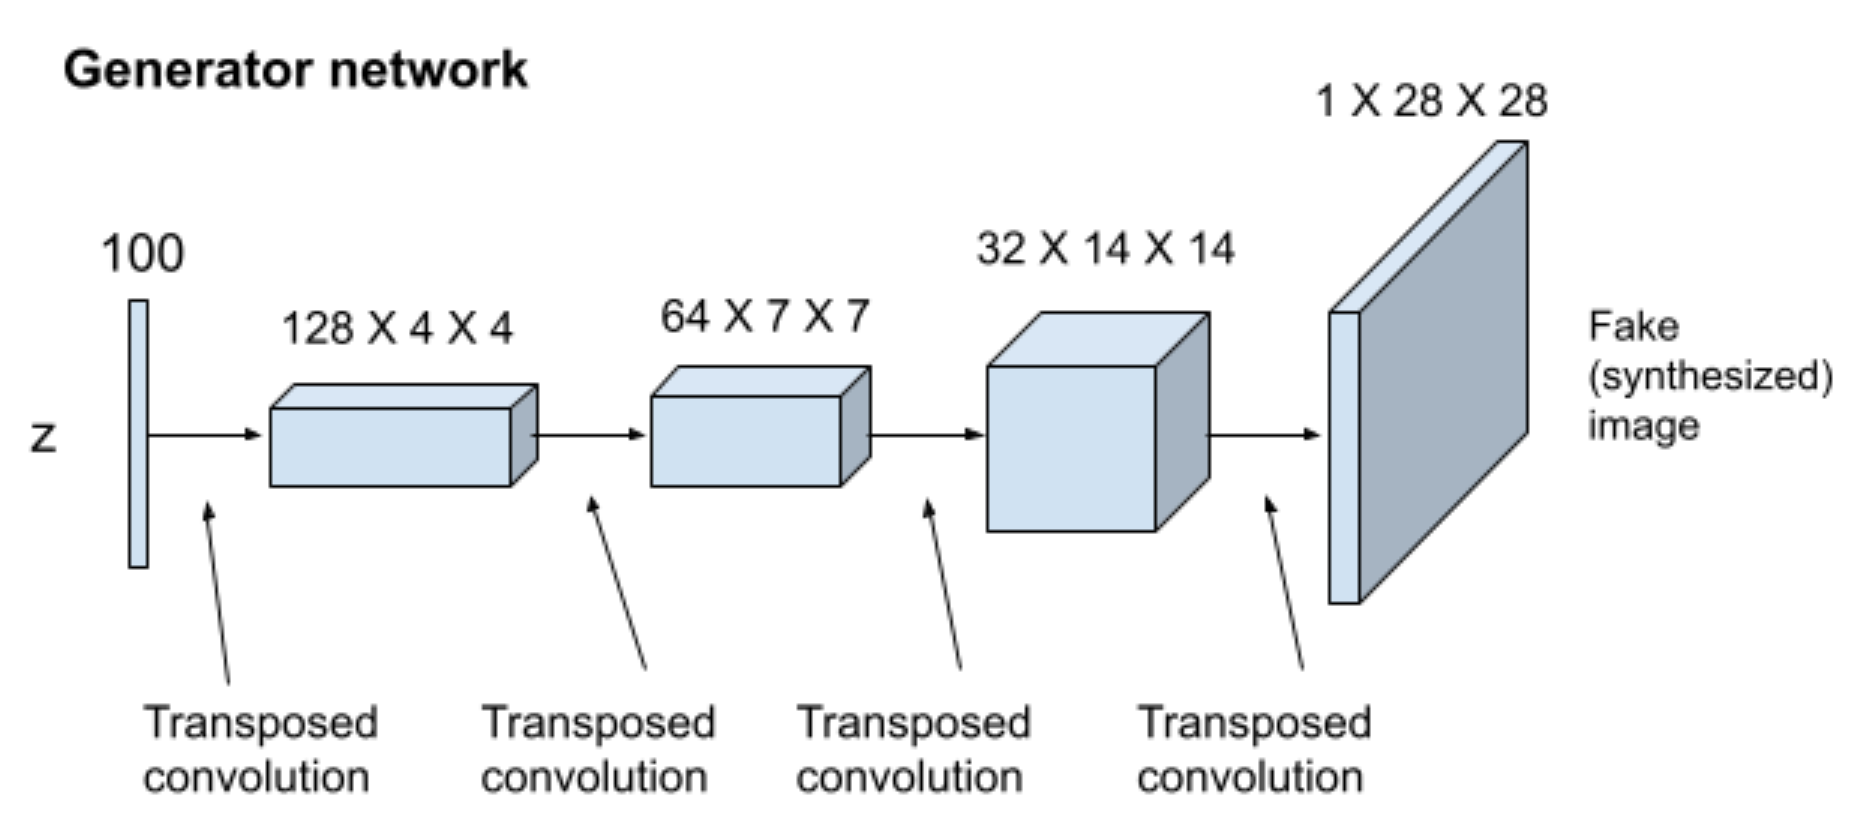

In [6]:
Image(filename='figures/17_12.png', width=700)

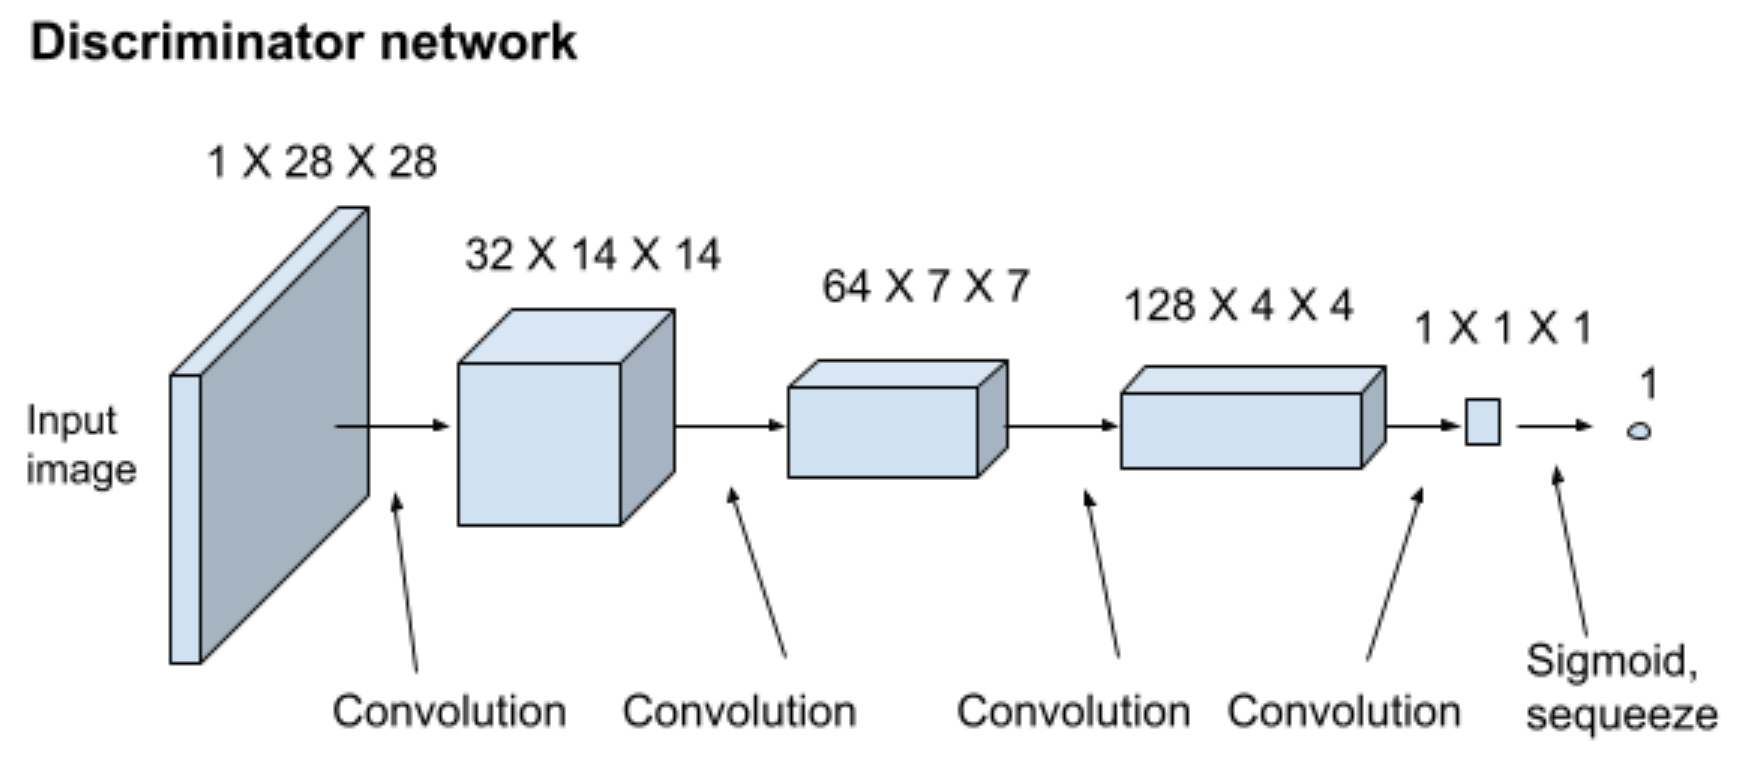

In [7]:
Image(filename='figures/17_13.png', width=700)

 * **Setting up the Google Colab**

In [8]:
#from google.colab import drive
#drive.mount('/content/drive/')

In [9]:
import torch


print(torch.__version__)
print("GPU Available:", torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = "cpu"

1.10.0+cu113
GPU Available: True


In [10]:
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Train the DCGAN model

In [11]:
import torchvision 
from torchvision import transforms 


image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])
mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=False)

batch_size = 64

torch.manual_seed(1)
np.random.seed(1)

## Set up the dataset
from torch.utils.data import DataLoader
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, 
                      shuffle=True, drop_last=True)


In [12]:
def make_generator_network(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0, 
                           bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class Discriminator(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)


In [13]:
z_size = 100
image_size = (28, 28)
n_filters = 32 
gen_model = make_generator_network(z_size, n_filters).to(device)  
print(gen_model)
disc_model = Discriminator(n_filters).to(device)     
print(disc_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)
Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [14]:
## Loss function and optimizers:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)


In [15]:
def create_noise(batch_size, z_size, mode_z):
    if mode_z == 'uniform':
        input_z = torch.rand(batch_size, z_size, 1, 1)*2 - 1 
    elif mode_z == 'normal':
        input_z = torch.randn(batch_size, z_size, 1, 1)
    return input_z

In [16]:
## Train the discriminator
def d_train(x):
    disc_model.zero_grad()

    # Train discriminator with a real batch
    batch_size = x.size(0)
    x = x.to(device)
    d_labels_real = torch.ones(batch_size, 1, device=device)

    d_proba_real = disc_model(x)
    d_loss_real = loss_fn(d_proba_real, d_labels_real)

    # Train discriminator on a fake batch
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    
    d_proba_fake = disc_model(g_output)
    d_labels_fake = torch.zeros(batch_size, 1, device=device)
    d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

    # gradient backprop & optimize ONLY D's parameters
    d_loss = d_loss_real + d_loss_fake
    d_loss.backward()
    d_optimizer.step()
  
    return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()


In [17]:
## Train the generator
def g_train(x):
    gen_model.zero_grad()
    
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_labels_real = torch.ones((batch_size, 1), device=device)

    g_output = gen_model(input_z)
    d_proba_fake = disc_model(g_output)
    g_loss = loss_fn(d_proba_fake, g_labels_real)

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()
        
    return g_loss.data.item()


In [18]:
mode_z = 'uniform'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
    g_output = g_model(input_z)
    images = torch.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

epoch_samples = []

num_epochs = 100
torch.manual_seed(1)

for epoch in range(1, num_epochs+1):    
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        d_loss, d_proba_real, d_proba_fake = d_train(x)
        d_losses.append(d_loss)
        g_losses.append(g_train(x))
 
    print(f'Epoch {epoch:03d} | Avg Losses >>'
          f' G/D {torch.FloatTensor(g_losses).mean():.4f}'
          f'/{torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 4.5246/0.1213
Epoch 002 | Avg Losses >> G/D 4.3550/0.1622
Epoch 003 | Avg Losses >> G/D 3.5067/0.2883
Epoch 004 | Avg Losses >> G/D 3.0862/0.3388
Epoch 005 | Avg Losses >> G/D 2.9113/0.3387
Epoch 006 | Avg Losses >> G/D 2.8452/0.3513
Epoch 007 | Avg Losses >> G/D 2.8693/0.3268
Epoch 008 | Avg Losses >> G/D 2.9476/0.3122
Epoch 009 | Avg Losses >> G/D 2.9538/0.3233
Epoch 010 | Avg Losses >> G/D 2.9754/0.3221
Epoch 011 | Avg Losses >> G/D 3.0405/0.2882
Epoch 012 | Avg Losses >> G/D 3.0717/0.2732
Epoch 013 | Avg Losses >> G/D 3.1362/0.2705
Epoch 014 | Avg Losses >> G/D 3.2441/0.2409
Epoch 015 | Avg Losses >> G/D 3.3397/0.2372
Epoch 016 | Avg Losses >> G/D 3.4194/0.2276
Epoch 017 | Avg Losses >> G/D 3.3906/0.2368
Epoch 018 | Avg Losses >> G/D 3.4867/0.2339
Epoch 019 | Avg Losses >> G/D 3.4793/0.2192
Epoch 020 | Avg Losses >> G/D 3.4953/0.2327
Epoch 021 | Avg Losses >> G/D 3.5337/0.2347
Epoch 022 | Avg Losses >> G/D 3.5944/0.1870
Epoch 023 | Avg Losses >> G/D 3.

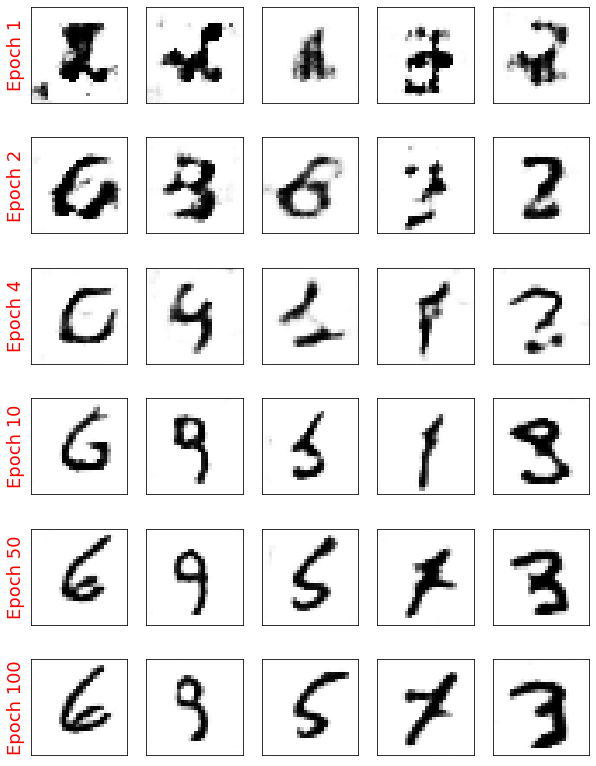

In [19]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
# plt.savefig('figures/ch17-dcgan-samples.pdf')
plt.show()

## Dissimilarity measures between two distributions 

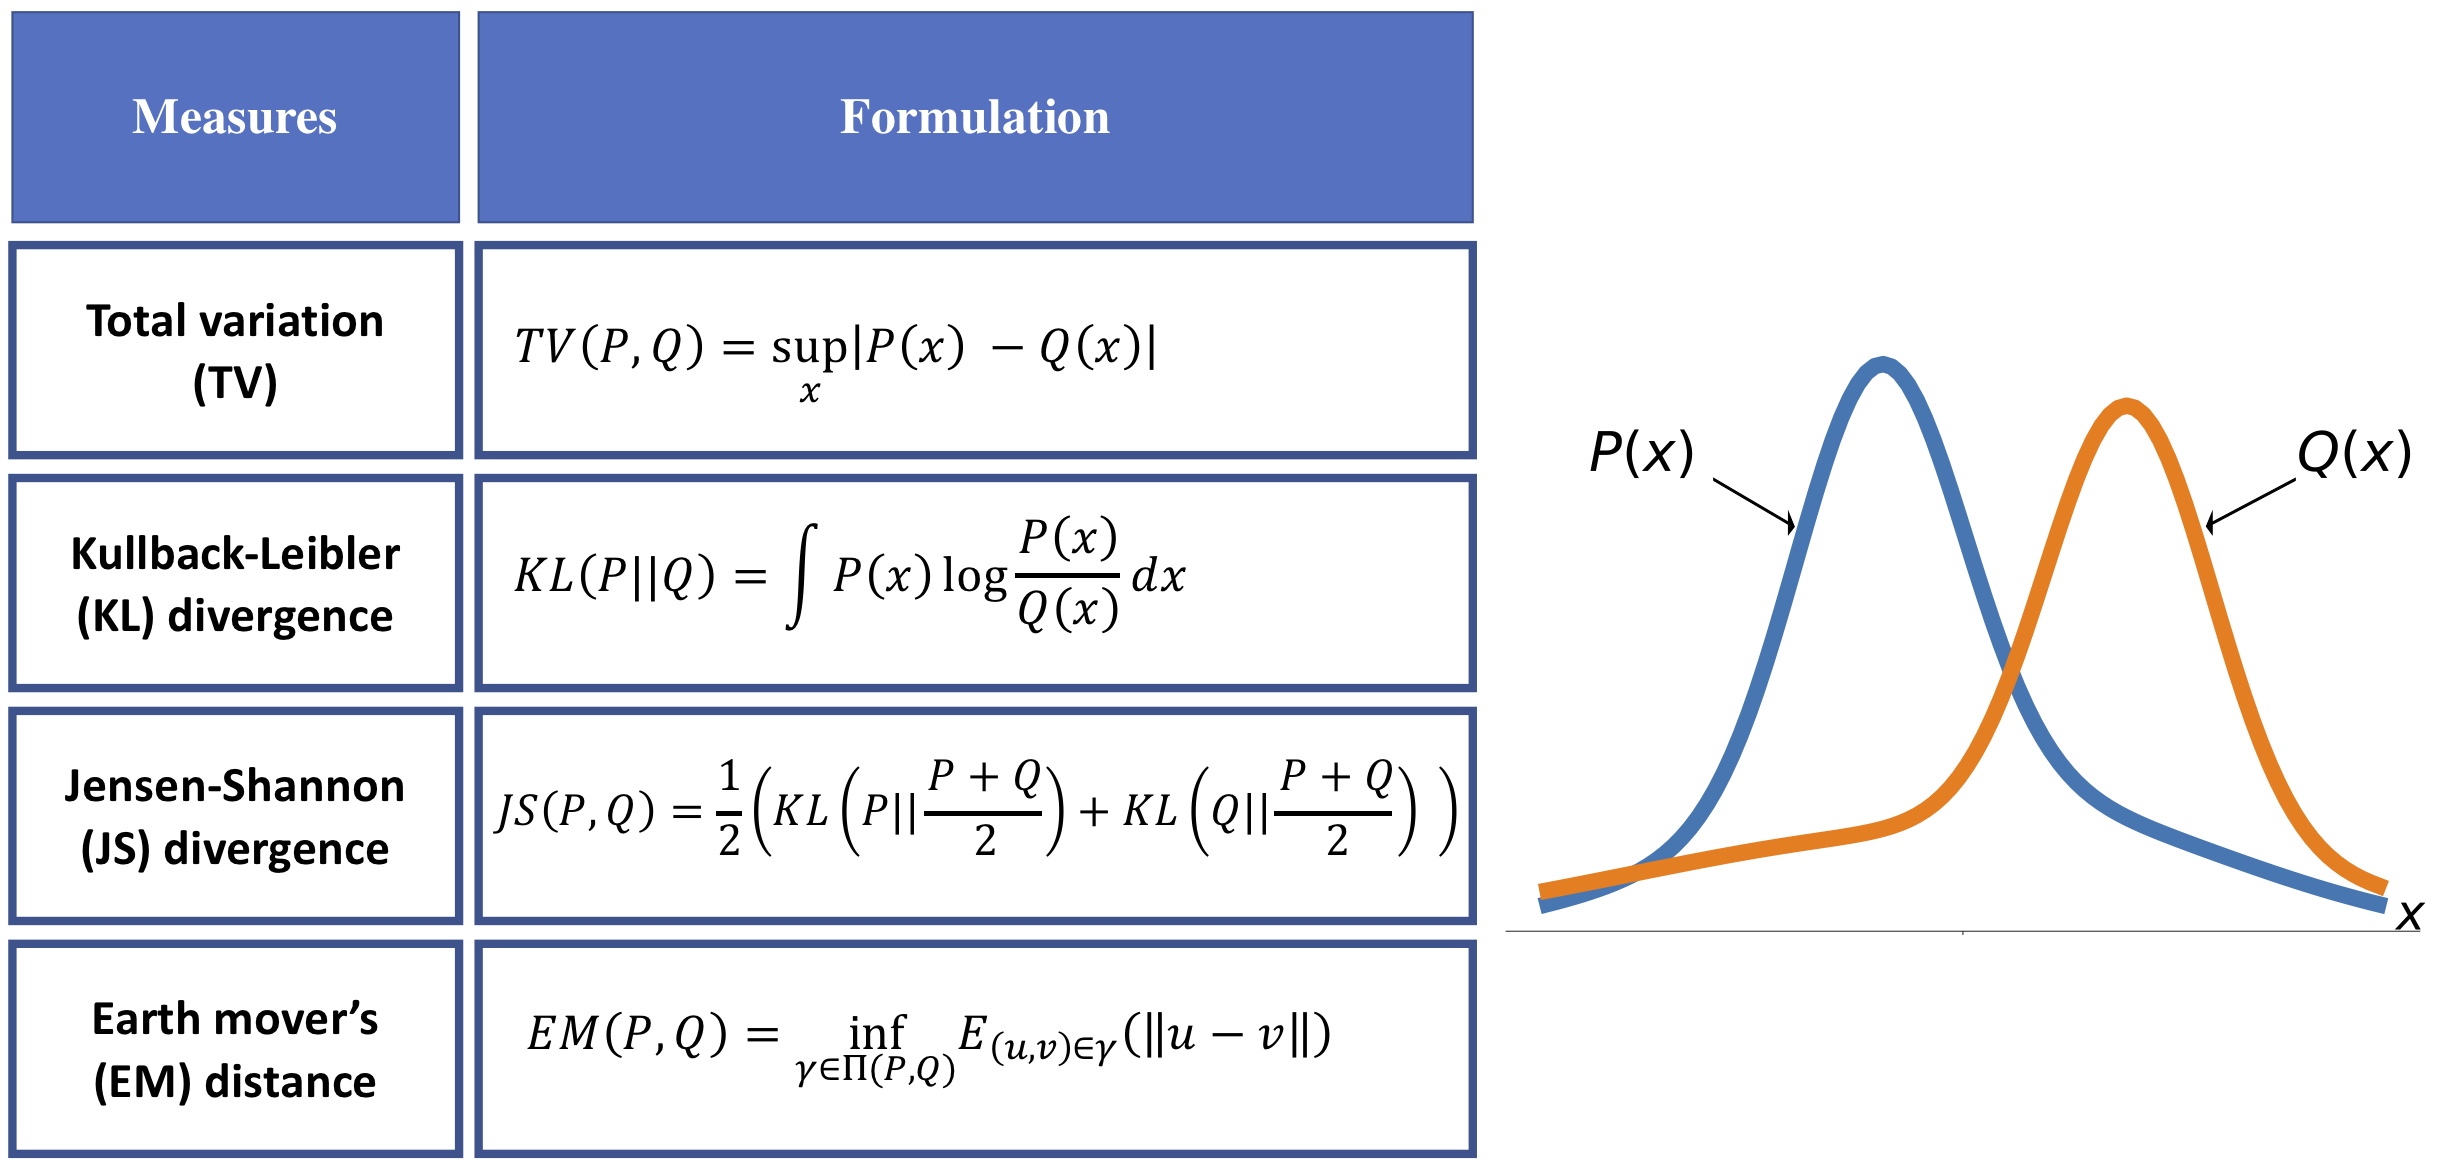

In [20]:
Image(filename='figures/17_14.png', width=700)

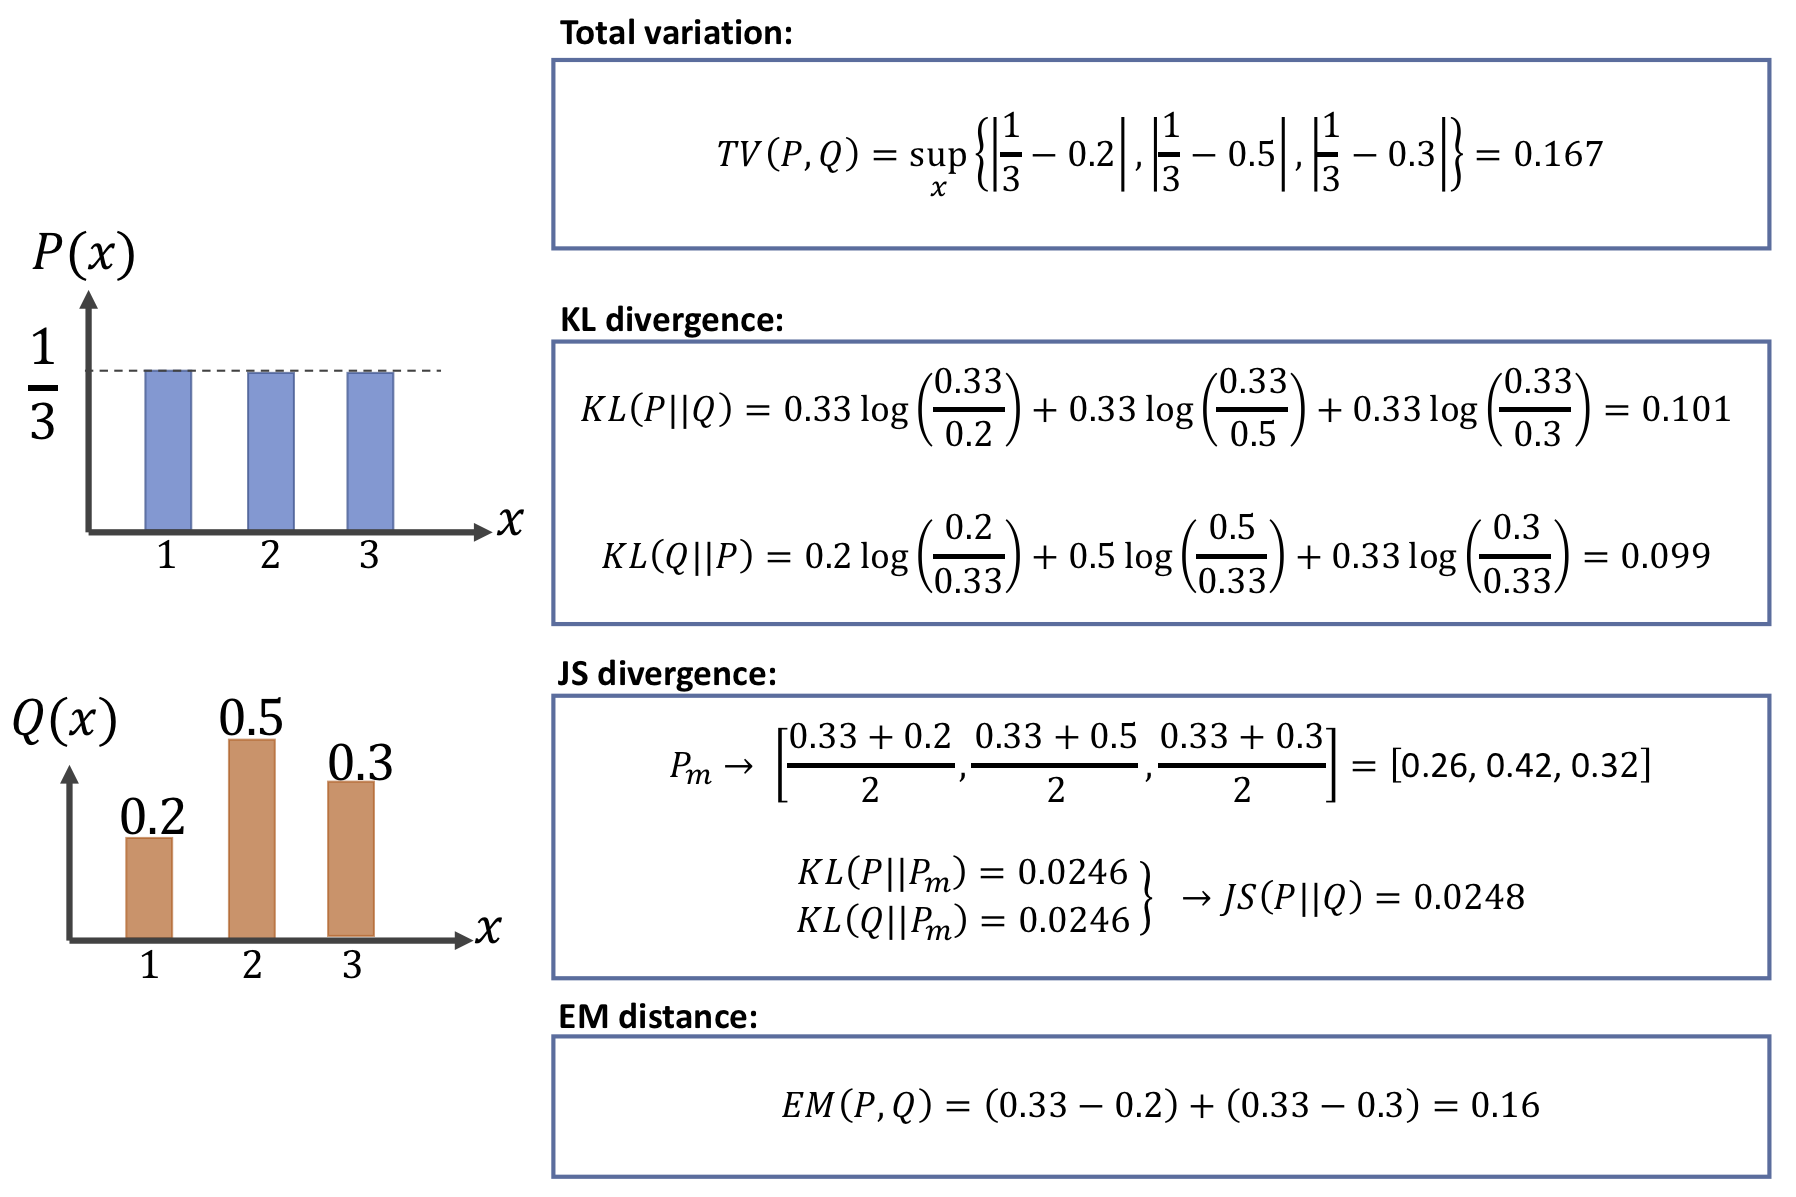

In [21]:
Image(filename='figures/17_15.png', width=800)

## Using EM distance in practice for GANs

## Gradient penalty 

## Implementing WGAN-GP to train the DCGAN model

In [22]:
def make_generator_network_wgan(input_size, n_filters):
    model = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 4, 1, 0, 
                           bias=False),
        nn.InstanceNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
        nn.Tanh())
    return model

class DiscriminatorWGAN(nn.Module):
    def __init__(self, n_filters):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters * 2),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
            nn.InstanceNorm2d(n_filters*4),
            nn.LeakyReLU(0.2),

            nn.Conv2d(n_filters*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid())
        
    def forward(self, input):
        output = self.network(input)
        return output.view(-1, 1).squeeze(0)

In [23]:
gen_model = make_generator_network_wgan(z_size, n_filters).to(device)  
disc_model = DiscriminatorWGAN(n_filters).to(device)  

g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0002)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [24]:
from torch.autograd import grad as torch_grad


def gradient_penalty(real_data, generated_data):
    batch_size = real_data.size(0)

    # Calculate interpolation
    alpha = torch.rand(real_data.shape[0], 1, 1, 1, requires_grad=True, device=device)
    interpolated = alpha * real_data + (1 - alpha) * generated_data
    
    # Calculate probability of interpolated examples
    proba_interpolated = disc_model(interpolated)

    # Calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=proba_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(proba_interpolated.size(), device=device),
                           create_graph=True, retain_graph=True)[0]

    gradients = gradients.view(batch_size, -1)
    gradients_norm = gradients.norm(2, dim=1)
    return lambda_gp * ((gradients_norm - 1)**2).mean()


In [25]:
## Train the discriminator
def d_train_wgan(x):
    disc_model.zero_grad()

    batch_size = x.size(0)
    x = x.to(device)

    # Calculate probabilities on real and generated data
    d_real = disc_model(x)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    d_generated = disc_model(g_output)
    d_loss = d_generated.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)
    d_loss.backward()
    d_optimizer.step()
  
    return d_loss.data.item()

In [26]:
## Train the generator
def g_train_wgan(x):
    gen_model.zero_grad()
    
    batch_size = x.size(0)
    input_z = create_noise(batch_size, z_size, mode_z).to(device)
    g_output = gen_model(input_z)
    
    d_generated = disc_model(g_output)
    g_loss = -d_generated.mean()

    # gradient backprop & optimize ONLY G's parameters
    g_loss.backward()
    g_optimizer.step()
        
    return g_loss.data.item()

In [29]:
epoch_samples_wgan = []
lambda_gp = 10.0
num_epochs = 100
torch.manual_seed(1)
critic_iterations = 5 

for epoch in range(1, num_epochs+1):    
    gen_model.train()
    d_losses, g_losses = [], []
    for i, (x, _) in enumerate(mnist_dl):
        for _ in range(critic_iterations):
            d_loss = d_train_wgan(x)
        d_losses.append(d_loss)
        g_losses.append(g_train_wgan(x))
 
    print(f'Epoch {epoch:03d} | D Loss >>'
          f' {torch.FloatTensor(d_losses).mean():.4f}')
    gen_model.eval()
    epoch_samples_wgan.append(
        create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | D Loss >> -0.5891
Epoch 002 | D Loss >> -0.6277
Epoch 003 | D Loss >> -0.6074
Epoch 004 | D Loss >> -0.6043
Epoch 005 | D Loss >> -0.5765
Epoch 006 | D Loss >> -0.5410
Epoch 007 | D Loss >> -0.5239
Epoch 008 | D Loss >> -0.4946
Epoch 009 | D Loss >> -0.4813
Epoch 010 | D Loss >> -0.4701
Epoch 011 | D Loss >> -0.4644
Epoch 012 | D Loss >> -0.4613
Epoch 013 | D Loss >> -0.4554
Epoch 014 | D Loss >> -0.4508
Epoch 015 | D Loss >> -0.4517
Epoch 016 | D Loss >> -0.4494
Epoch 017 | D Loss >> -0.4498
Epoch 018 | D Loss >> -0.4505
Epoch 019 | D Loss >> -0.4476
Epoch 020 | D Loss >> -0.4534
Epoch 021 | D Loss >> -0.4516
Epoch 022 | D Loss >> -0.4560
Epoch 023 | D Loss >> -0.4531
Epoch 024 | D Loss >> -0.4543
Epoch 025 | D Loss >> -0.4548
Epoch 026 | D Loss >> -0.4536
Epoch 027 | D Loss >> -0.4508
Epoch 028 | D Loss >> -0.4526
Epoch 029 | D Loss >> -0.4547
Epoch 030 | D Loss >> -0.4585
Epoch 031 | D Loss >> -0.4624
Epoch 032 | D Loss >> -0.4575
Epoch 033 | D Loss >> -0.4569
Epoch 034 

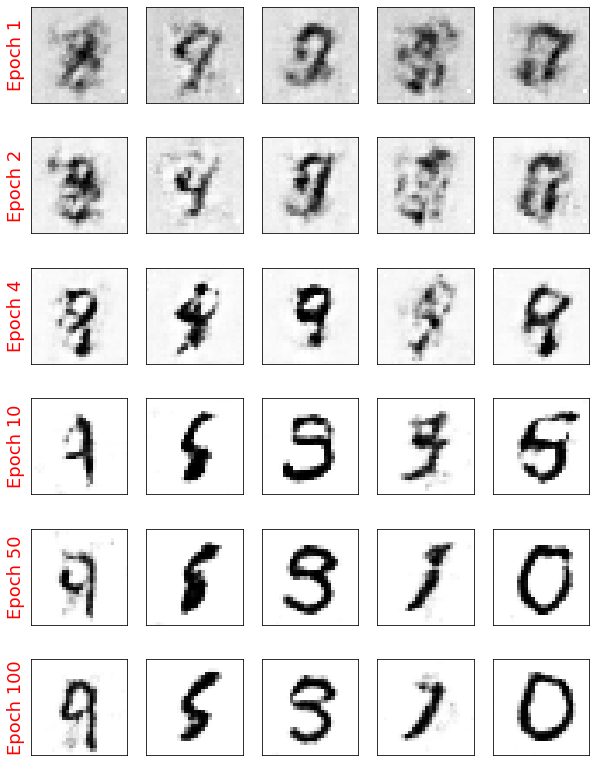

In [30]:
selected_epochs = [1, 2, 4, 10, 50, 100]
# selected_epochs = [1, 10, 20, 30, 50, 70]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
    for j in range(5):
        ax = fig.add_subplot(6, 5, i*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, f'Epoch {e}',
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples_wgan[e-1][j]
        ax.imshow(image, cmap='gray_r')
    
# plt.savefig('figures/ch17-wgan-gp-samples.pdf')
plt.show()


## Mode collapse

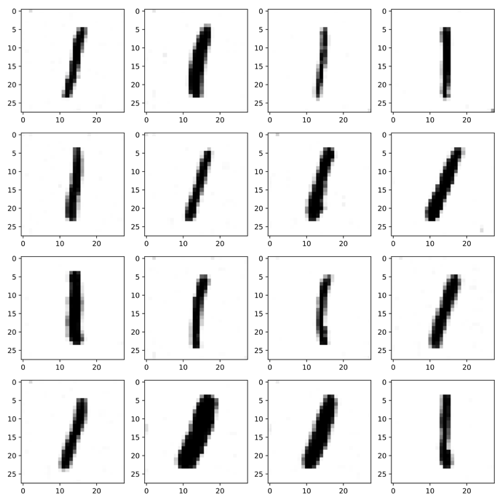

In [31]:
Image(filename='figures/17_16.png', width=600)

<br>
<br>

----



Readers may ignore the next cell.



In [4]:
! python ../.convert_notebook_to_script.py --input ch17_part2.ipynb --output ch17_part2.py

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook ch17_part2.ipynb to script
[NbConvertApp] Writing 13766 bytes to ch17_part2.py
